# Basic Neural Network 

(to compare pre-transfer learning)

In [25]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

# Bring in split datasets

In [6]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

In [8]:
X_unseen_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_unseen.nc').to_dataframe().dropna() 
y_unseen_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_unseen.nc').to_dataframe().dropna() 

## To test normalization:

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

In [9]:
X_df_norm = (X_df - X_df.mean())/X_df.std() 
y_df_norm = (y_df - y_df.mean())/y_df.std()
X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

## Create numpy arrays for both regular and normalized dataframes

In [10]:
X = X_df.to_numpy()         
y = y_df.to_numpy().ravel() 
X_train = X_train_df.to_numpy() 
y_train = y_train_df.to_numpy().ravel()
X_test = X_test_df.to_numpy()  
y_test = y_test_df.to_numpy().ravel()

X_n = X_df_norm.to_numpy()         
y_n = y_df_norm.to_numpy().ravel() 
X_train_n = X_train_df_norm.to_numpy()
y_train_n = y_train_df_norm.to_numpy().ravel()
X_test_n = X_test_df_norm.to_numpy() 
y_test_n = y_test_df_norm.to_numpy().ravel()

## Building and Training the NN Model

In [1]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [11]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [16]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model.add(Dense(y_train_df.shape[1],  activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [18]:
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                704       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 1507.2157 - val_loss: 728.0276
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 744.3271 - val_loss: 753.5252
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 687.2758 - val_loss: 781.7056
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 645.9800 - val_loss: 728.7307
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 599.8337 - val_loss: 636.5508
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 558.8230 - val_loss: 595.3566
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 511.7632 - val_loss: 480.7850
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 460.2603 - val_loss: 497.5888
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 428.2924 - val_loss: 558.7802
Epoch 10/50
2483/2483 [======================

In [23]:
y_pred = NN_model.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 636us/step
MSE: 201.85


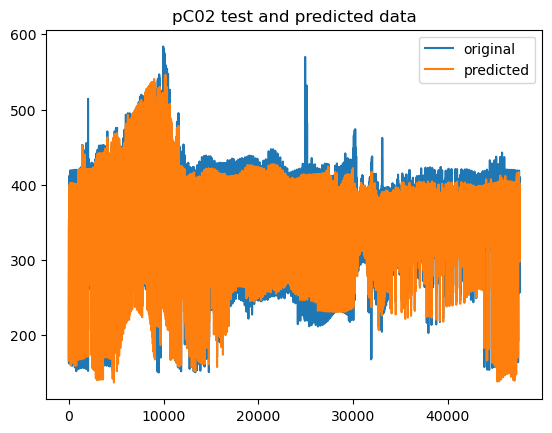

In [26]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

In [ ]:
# after training, save:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [ ]:
model.save(os.path.join(model_path,'NN_model.h5'))

## Testing the NN Model

In [ ]:
# then reload before start working with test data
model = load_model(os.path.join(model_path,'NN_model.h5'))